# Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
from os import listdir

from PIL import Image
from sklearn import metrics
import tensorflow as tf

import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Data Information

In [2]:
path = '/kaggle/input/images/Dataset Real'
print('List dir:')
for file in os.listdir(path):
  print(file)

List dir:
Validations
Train


In [3]:
TRAIN_DIR = os.path.join(path, 'Train')
VALIDATION_DIR = os.path.join(path, 'Validations')

In [4]:
healthy_train_dir = os.path.join(TRAIN_DIR, 'Healthy Food')
unhealthy_train_dir = os.path.join(TRAIN_DIR, 'Unhealthy Food')
healthy_validation_dir = os.path.join(VALIDATION_DIR, 'Healthy Food')
unhealthy_validation_dir = os.path.join(VALIDATION_DIR, 'Unhealthy Food')

# Display Images

In [5]:
def display_images(image_dir, title, num_images=9):
    image_files = os.listdir(image_dir)[:num_images]
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    axes = axes.flatten()

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)
        try:
            img = Image.open(image_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error opening {image_path}: {e}")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

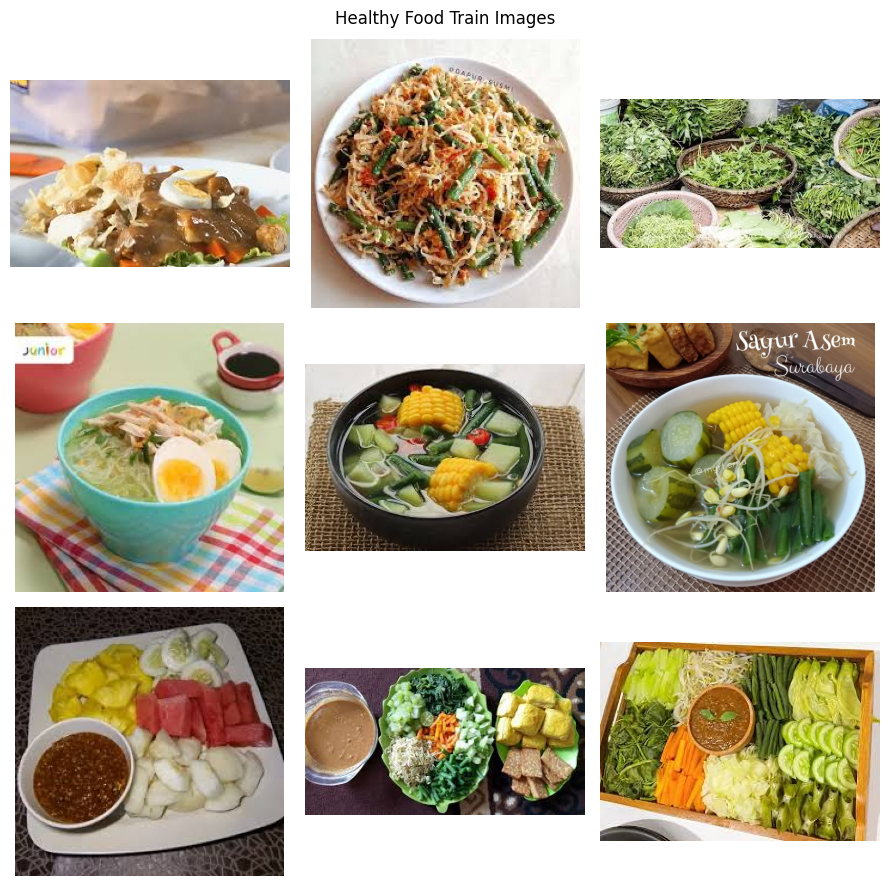

In [6]:
display_images(healthy_train_dir, 'Healthy Food Train Images')

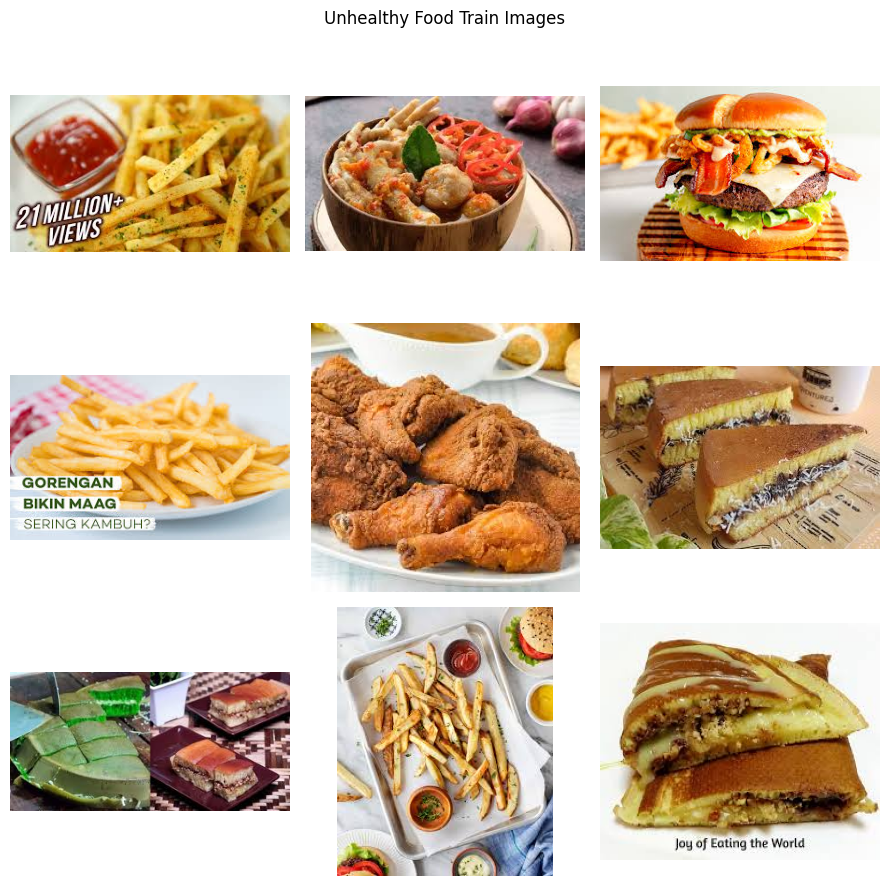

In [7]:
display_images(unhealthy_train_dir, 'Unhealthy Food Train Images')

# Data Augmentation

In [8]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range = 0.2,
    fill_mode = 'nearest',
)

test_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

In [9]:
training_data = train_image_gen.flow_from_directory(
    TRAIN_DIR,
    class_mode='binary',
    target_size=(224, 224),
    batch_size=128,
    shuffle=True,
)

validation_data = test_image_gen.flow_from_directory(
    VALIDATION_DIR,
    class_mode='binary',
    target_size=(224, 224),
    batch_size=128,
    shuffle=True,
)

Found 2556 images belonging to 2 classes.
Found 646 images belonging to 2 classes.


# Data Modeling

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6
)

In [12]:
history = model.fit(training_data,epochs=10,
                    validation_data=validation_data,
                    callbacks=[reduce_lr])

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.5259 - loss: 0.7156 - val_accuracy: 0.6734 - val_loss: 0.6310 - learning_rate: 1.0000e-04
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 178s 8s/step - accuracy: 0.6734 - loss: 0.6262 - val_accuracy: 0.7059 - val_loss: 0.5679 - learning_rate: 1.0000e-04
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 9s/step - accuracy: 0.7104 - loss: 0.5814 - val_accuracy: 0.7663 - val_loss: 0.5368 - learning_rate: 1.0000e-04
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 179s 8s/step - accuracy: 0.7193 - loss: 0.5537 - val_accuracy: 0.7663 - val_loss: 0.5172 - learning_rate: 1.0000e-04
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 179s 8s/step - accuracy: 0.7456 - loss: 0.5119 - val_accuracy: 0.7430 - val_loss: 0.5190 - learning_rate: 1.0000e-04
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.7650 - loss: 0.4921 - val_accuracy: 0.7957 - val_loss: 0.4761 - learning_rate: 1.0000e-04
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 180s 8s/step - accuracy: 0.8025 

# Prediction

In [13]:
def plot_predictions(model, dataset, class_names, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    counter = 0

    for batch_x, batch_y in dataset:  # Iterasi dataset batch
        for image, label in zip(batch_x, batch_y):  
            predictions = model.predict(tf.expand_dims(image, axis=0), verbose=0)
            predicted_label = int(predictions[0][0] > 0.5) 
            axes[counter].imshow(image)  
            axes[counter].set_title(f"True: {class_names[int(label)]}, Pred: {class_names[predicted_label]}")
            axes[counter].axis("off")
            counter += 1
            
            if counter >= num_images:
                break
        if counter >= num_images:
            break

    plt.tight_layout()
    plt.show()

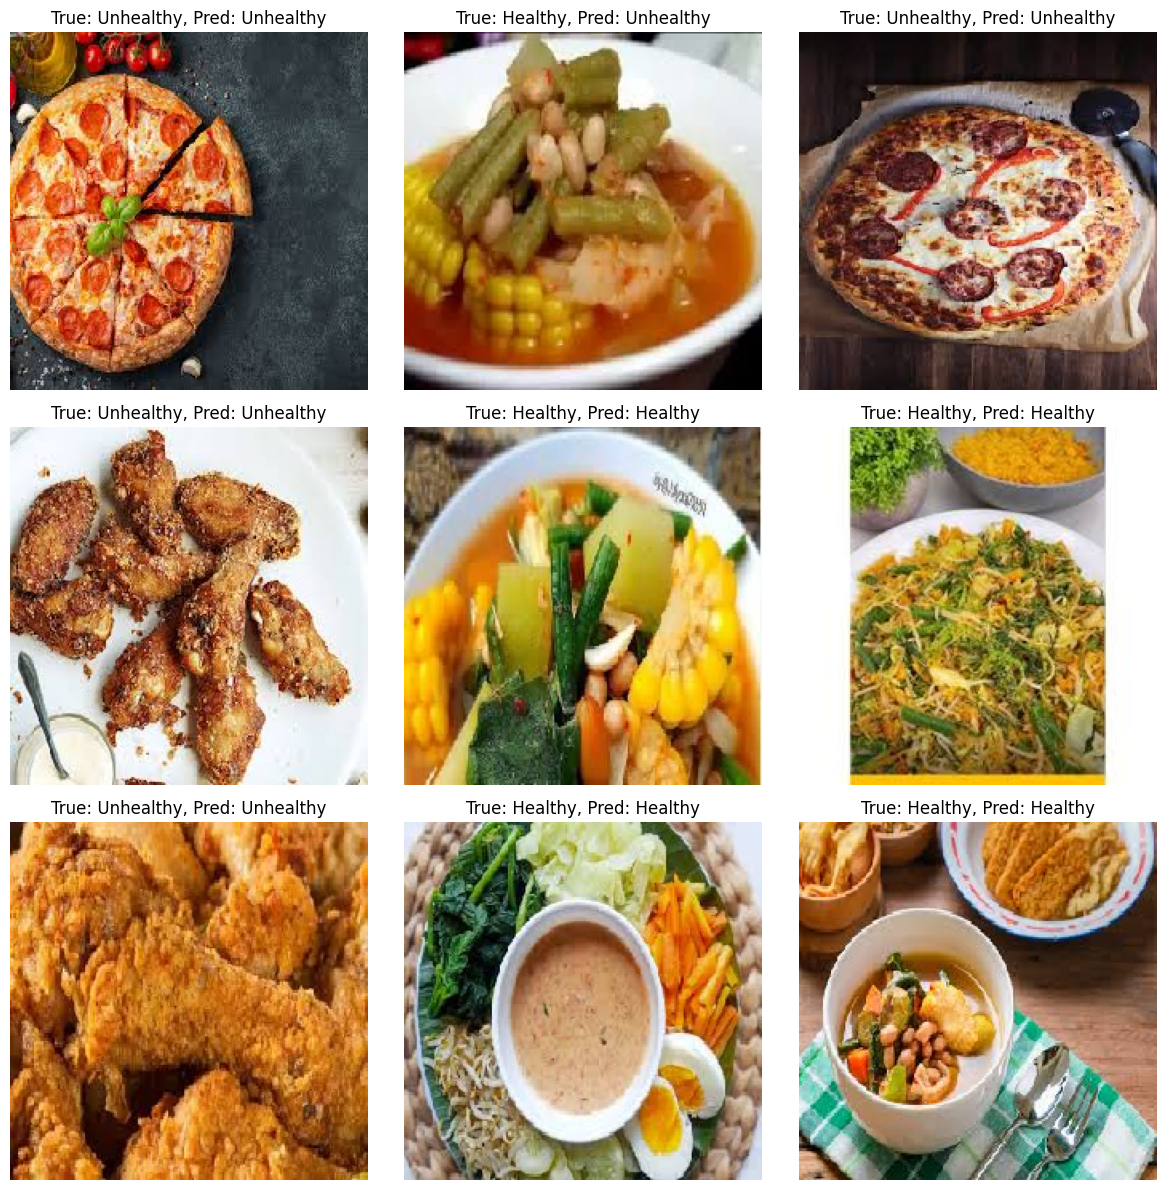

In [14]:
class_names = ["Healthy", "Unhealthy"]

plot_predictions(model, validation_data, class_names, num_images=9)

# Model Evaluation

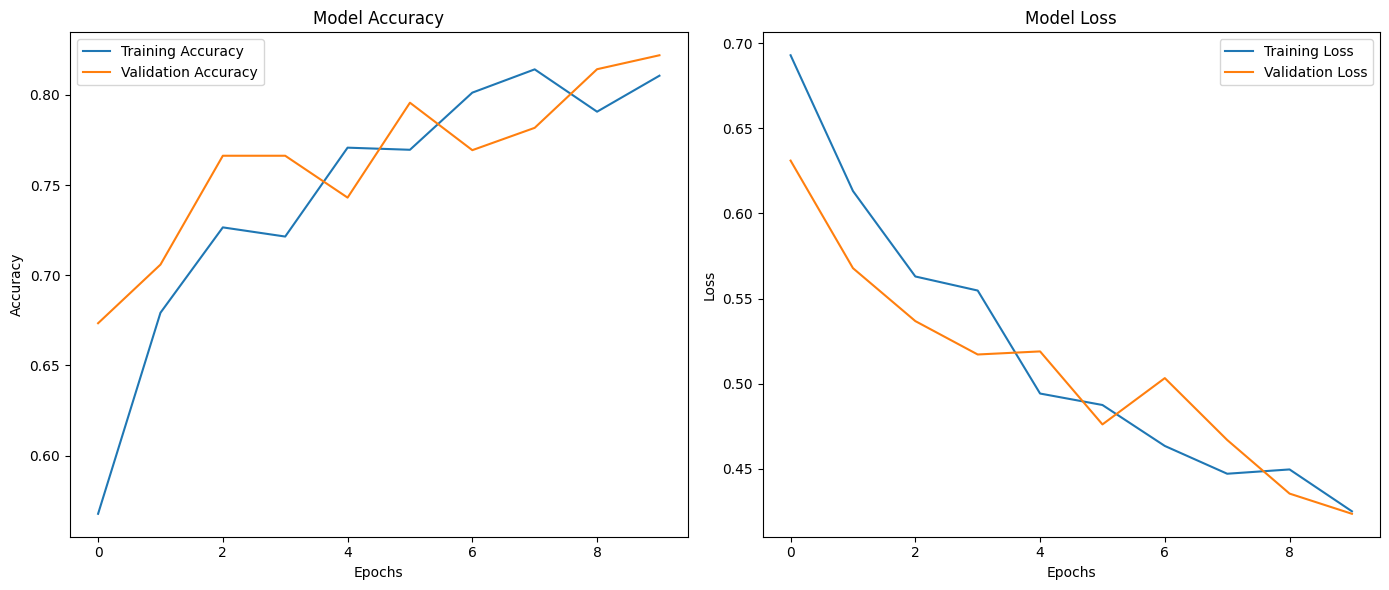

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

# Save Model

In [16]:
model.save("model_Healthy or Unhealthy Binary Image Classification.h5")

In [17]:
model_json = model.to_json()
with open("model_Healthy or Unhealthy Binary Image Classification architecture.json", "w") as json_file:
    json_file.write(model_json)

In [18]:
weights = model.get_weights()
with open('model_Healthy or Unhealthy Binary Image Classification weights.bin', 'wb') as bin_file:
    for weight_array in weights:
        weight_array.astype(np.float32).tofile(bin_file)